In [40]:
import os
import json
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [41]:
def unnormalised_best_subspan_em(
    prediction, ground_truths
) -> float:
    for ground_truth in ground_truths:
        if ground_truth.lower() in prediction.lower():
            return 1.0
    return 0.0

In [56]:
decore_cb_filepath = "../predictions/musique_closed_book/pred_MuSiQue_DeCoReEntropy.json"
decore_ob_filepath = "../predictions/musique_open_book/pred_MuSiQue_DeCoReEntropy.json"
baseline_cb_filepath = "../predictions/musique_closed_book/pred_MuSiQue_Baseline.json"
baseline_ob_filepath = "../predictions/musique_open_book/pred_MuSiQue_Baseline.json"
dola_cb_filepath = "../predictions/musique_closed_book/pred_MuSiQue_DoLa.json"
dola_ob_filepath = "../predictions/musique_open_book/pred_MuSiQue_DoLa.json"

def load_data(filepath):
    data = []
    with open(filepath, "r") as f:
        for line in f:
            data += [json.loads(line)]
    
    predicted_answers = []
    paragraphs = []
    questions = []
    answers = []
    alphas = []
    lengths = []
    labels = []
    for i in range(len(data)):
        answers_list = [ans[0] for ans in data[i]["answers"]]

        is_correct = unnormalised_best_subspan_em(data[i]["predicted_answer"], answers_list)

        paragraphs += [data[i]["paragraphs"] if "paragraphs" in data[i] else []]
        questions += [data[i]["question"]]
        answers += [answers_list]
        predicted_answers += [data[i]["predicted_answer"]]
        alphas += [data[i]["alphas"]]
        lengths += [len(data[i]["alphas"])]
        labels += [is_correct]

    return {
        "paragraphs": paragraphs,
        "questions": questions,
        "answers": answers,
        "predicted_answers": predicted_answers,
        "alphas": alphas,
        "lengths": lengths,
        "labels": labels
    }
    
decore_cb_data = load_data(decore_cb_filepath)
decore_ob_data = load_data(decore_ob_filepath)
baseline_cb_data = load_data(baseline_cb_filepath)
baseline_ob_data = load_data(baseline_ob_filepath)
dola_cb_data = load_data(dola_cb_filepath)
dola_ob_data = load_data(dola_ob_filepath)

In [72]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(closed_book_predictions, open_book_predictions):
    # Create a confusion matrix with labels for both 0 and 1
    cm = confusion_matrix(closed_book_predictions, open_book_predictions, labels=[0, 1])
    
    # Convert the confusion matrix to a pandas DataFrame
    cm_df = pd.DataFrame(cm, index=['Incorrect', 'Correct'], columns=['Incorrect', 'Correct'])
    
    # Normalize the confusion matrix by dividing by the sum of all values
    cm_percentage = cm_df / cm_df.sum().sum() * 100

    # Calculate the Open book correct AND Closed book incorrect / Closed book Incorrect
    open_correct_closed_incorrect = cm_df.loc['Incorrect', 'Correct'] / cm_df.loc['Incorrect'].sum()

    # Calculate Closed book correct AND Open book incorrect / (Closed book Incorrect AND Open book Incorrect + Closed book Correct AND Open book Incorrect)
    closed_correct_open_incorrect = cm_df.loc['Correct', 'Incorrect'] / (cm_df.loc['Correct', 'Incorrect'] + cm_df.loc['Incorrect', 'Incorrect'])

    print(cm_df.loc['Incorrect', 'Correct'])
    print(cm_df.loc['Incorrect'].sum())

    print("Open book correct AND Closed book incorrect / Closed book Incorrect: {:.2f}%".format(open_correct_closed_incorrect*100))
    print("Closed book correct AND Open book incorrect / Closed book correct: {:.2f}%".format(closed_correct_open_incorrect*100))
    
    # Print the percentage DataFrame to verify
    print("Confusion Matrix Percentage DataFrame:")
    print(cm_df)
    print(cm_percentage)
    
    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm_percentage, cmap='Blues')

    for (i, j), val in np.ndenumerate(cm_percentage.values):
        ax.text(j, i, f'{val:.2f}%', ha='center', va='center', color='black', fontsize=14)
    
    plt.xlabel('Open Book Predictions')
    plt.ylabel('Closed Book Predictions')
    plt.title('Confusion Matrix (Percentage)')
    plt.colorbar(cax)
    plt.xticks(range(len(cm_percentage.columns)), cm_percentage.columns, rotation=45)
    plt.yticks(range(len(cm_percentage.index)), cm_percentage.index)
    plt.show()

1465
2051
Open book correct AND Closed book incorrect / Closed book Incorrect: 71.43%
Closed book correct AND Open book incorrect / Closed book correct: 5.18%
Confusion Matrix Percentage DataFrame:
           Incorrect  Correct
Incorrect        586     1465
Correct           32      334
           Incorrect    Correct
Incorrect  24.244932  60.612329
Correct     1.323955  13.818784


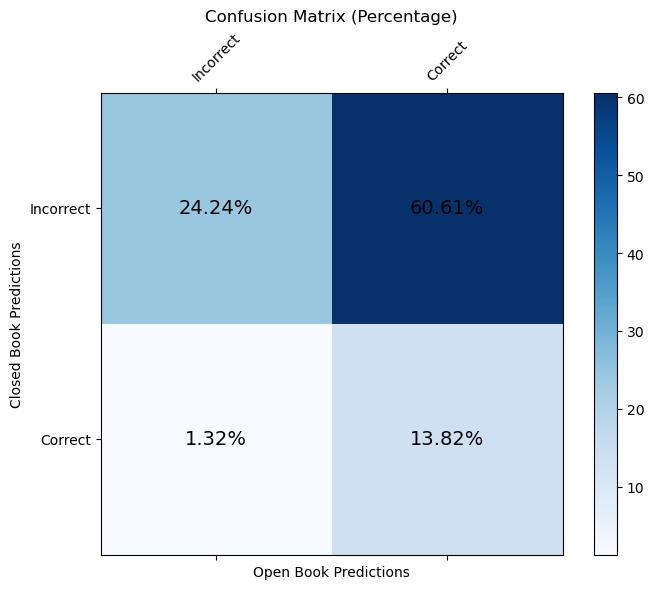

In [73]:
plot_confusion_matrix(decore_cb_data["labels"], decore_ob_data["labels"])

1382
2036
Open book correct AND Closed book incorrect / Closed book Incorrect: 67.88%
Closed book correct AND Open book incorrect / Closed book correct: 4.39%
Confusion Matrix Percentage DataFrame:
           Incorrect  Correct
Incorrect        654     1382
Correct           30      351
           Incorrect    Correct
Incorrect  27.058337  57.178320
Correct     1.241208  14.522135


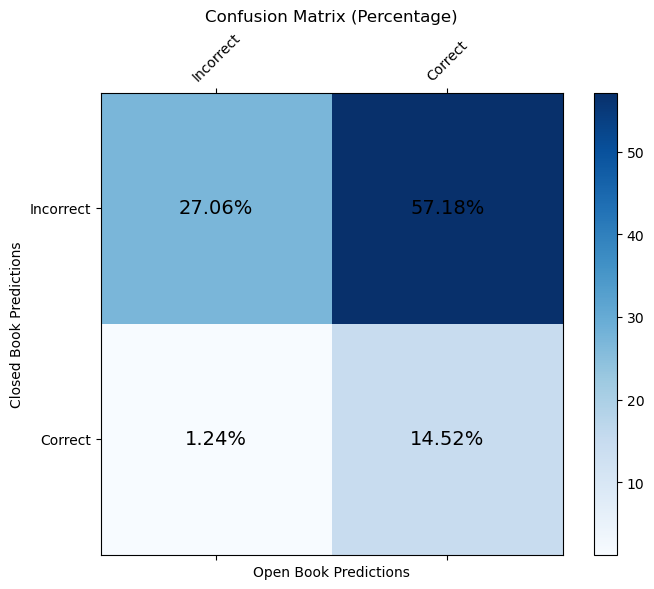

In [74]:
plot_confusion_matrix(baseline_cb_data["labels"], baseline_ob_data["labels"])

1385
2041
Open book correct AND Closed book incorrect / Closed book Incorrect: 67.86%
Closed book correct AND Open book incorrect / Closed book correct: 5.61%
Confusion Matrix Percentage DataFrame:
           Incorrect  Correct
Incorrect        656     1385
Correct           39      337
           Incorrect    Correct
Incorrect  27.141084  57.302441
Correct     1.613571  13.942904


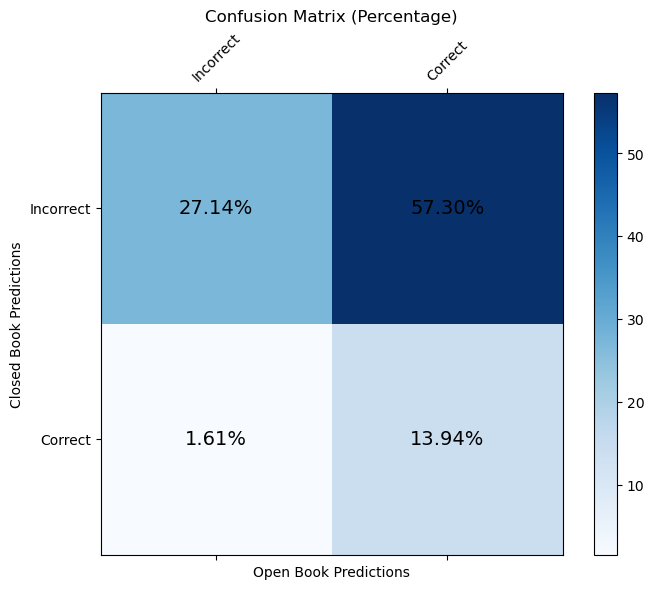

In [75]:
plot_confusion_matrix(dola_cb_data["labels"], dola_ob_data["labels"])

In [78]:
decore_idx = []
decore_cb_incorrect_ob_correct_idx = []

for idx, (cb_label, ob_label) in enumerate(zip(decore_cb_data["labels"], decore_ob_data["labels"])):
    if cb_label and not ob_label:
        print("=====================================")
        print("IDX: ", idx)
        print("Paragraphs: ", decore_ob_data["paragraphs"][idx])
        print("Question: ", decore_cb_data["questions"][idx])
        print("Answers: ", decore_cb_data["answers"][idx])
        print("Closed book: ", decore_cb_data["predicted_answers"][idx])
        print("Open book: ", decore_ob_data["predicted_answers"][idx])
        print("=====================================")
        decore_idx += [idx]
    if not cb_label and ob_label:
        decore_cb_incorrect_ob_correct_idx += [idx]

IDX:  175
Paragraphs:  [{'title': ['Westminster Abbey'], 'paragraph_text': ['Since the coronations in 1066 of both King Harold and William the Conqueror, coronations of English and British monarchs were held in the abbey. In 1216, Henry III was unable to be crowned in London when he first came to the throne, because the French prince Louis had taken control of the city, and so the king was crowned in Gloucester Cathedral. This coronation was deemed by the Pope to be improper, and a further coronation was held in the abbey on 17 May 1220. The Archbishop of Canterbury is the traditional cleric in the coronation ceremony.[citation needed]']}, {'title': ['Westminster Abbey'], 'paragraph_text': ['The chapter house was built concurrently with the east parts of the abbey under Henry III, between about 1245 and 1253. It was restored by Sir George Gilbert Scott in 1872. The entrance is approached from the east cloister walk and includes a double doorway with a large tympanum above.']}]
Question

In [79]:
baseline_idx = []
baseline_cb_incorrect_ob_incorrect_idx = []

for idx, (cb_label, ob_label) in enumerate(zip(baseline_cb_data["labels"], baseline_ob_data["labels"])):
    if cb_label and not ob_label:
        print("=====================================")
        print("IDX: ", idx)
        print("Paragraphs: ", baseline_ob_data["paragraphs"][idx])
        print("Question: ", baseline_cb_data["questions"][idx])
        print("Answers: ", baseline_cb_data["answers"][idx])
        print("Closed book: ", baseline_cb_data["predicted_answers"][idx])
        print("Open book: ", baseline_ob_data["predicted_answers"][idx])
        print("=====================================")
        baseline_idx += [idx]
    if not cb_label and not ob_label:
        baseline_cb_incorrect_ob_incorrect_idx += [idx]

IDX:  153
Paragraphs:  [{'title': ['C. V. Raman'], 'paragraph_text': ["Sir Chandrashekhara Venkata Raman (; 7 November 1888 – 21 November 1970) was an Indian physicist born in the former Madras Province in India (presently the state of Tamil Nadu), who carried out ground-breaking work in the field of light scattering, which earned him the 1930 Nobel Prize for Physics. He discovered that when light traverses a transparent material, some of the deflected light changes  wavelength and amplitude. This phenomenon, subsequently known as Raman scattering, results from the Raman effect. In 1954, the Indian government honoured him with India's highest civilian award, the Bharat Ratna."]}, {'title': ['A. P. J. Abdul Kalam'], 'paragraph_text': ["A.P.J. Abdul Kalam 11th President of India In office 25 July 2002 -- 25 July 2007 Prime Minister Atal Bihari Vajpayee Manmohan Singh Vice President Krishan Kant Bhairon Singh Shekhawat Preceded by K.R. Narayanan Succeeded by Pratibha Patil Personal detail

In [64]:
dola_idx = []

for idx, (cb_label, ob_label) in enumerate(zip(dola_cb_data["labels"], dola_ob_data["labels"])):
    if cb_label and not ob_label:
        print("=====================================")
        print("IDX: ", idx)
        print("Paragraphs: ", dola_ob_data["paragraphs"][idx])
        print("Question: ", dola_cb_data["questions"][idx])
        print("Answers: ", dola_cb_data["answers"][idx])
        print("Closed book: ", dola_cb_data["predicted_answers"][idx])
        print("Open book: ", dola_ob_data["predicted_answers"][idx])
        print("=====================================")
        dola_idx += [idx]

IDX:  88
Paragraphs:  [{'title': ['Cape Verde'], 'paragraph_text': ['Cape Verde ( (listen)) or Cabo Verde ( (listen), ) (Portuguese: Cabo Verde, pronounced [ˈkabu ˈveɾdɨ]), officially the Republic of Cabo Verde, is an island country spanning an archipelago of 10 volcanic islands in the central Atlantic Ocean. It forms part of the Macaronesia ecoregion, along with the Azores, Canary Islands, Madeira, and the Savage Isles. In ancient times these islands were referred to as "the Islands of the Blessed" or the "Fortunate Isles". Located 570 kilometres (350 mi) west of the Cape Verde Peninsula off the coast of Northwest Africa, the islands cover a combined area of slightly over 4,000 square kilometres (1,500 sq mi).']}, {'title': ['ISO 3166-2:CV'], 'paragraph_text': ['ISO 3166-2:CV is the entry for Cabo Verde in ISO 3166-2, part of the ISO 3166 standard published by the International Organization for Standardization (ISO), which defines codes for the names of the principal subdivisions (e.g

In [68]:
for idx in list(set(decore_idx) - set(baseline_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Paragraphs: ", decore_ob_data["paragraphs"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

IDX:  1808
Paragraphs:  [{'title': ['Gothic architecture'], 'paragraph_text': ["The Palais des Papes in Avignon is the best complete large royal palace, alongside the Royal palace of Olite, built during the 13th and 14th centuries for the kings of Navarre. The Malbork Castle built for the master of the Teutonic order is an example of Brick Gothic architecture. Partial survivals of former royal residences include the Doge's Palace of Venice, the Palau de la Generalitat in Barcelona, built in the 15th century for the kings of Aragon, or the famous Conciergerie, former palace of the kings of France, in Paris."]}, {'title': ['Codo, Aragon'], 'paragraph_text': ['Codo is a municipality located in the province of Zaragoza, Aragon, Spain. According to the 2008 census (INE), the municipality has a population of 228 inhabitants.']}, {'title': ['Martin of Aragon'], 'paragraph_text': ['Martin the Humane (29 July 1356 – 31 May 1410), also called the Elder and the Ecclesiastic, was King of Aragon, V

In [76]:
for idx in list(set(baseline_idx) - set(decore_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Paragraphs: ", decore_ob_data["paragraphs"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

IDX:  643
Paragraphs:  [{'title': ['The Bourne Legacy (film)'], 'paragraph_text': ['The titular character Jason Bourne does not appear in The Bourne Legacy, because actor Matt Damon chose not to return for the fourth film, due to Paul Greengrass not directing. Bourne is shown in pictures and mentioned by name several times throughout the film. Tony Gilroy, co-screenwriter of the first three films, sought to continue the story of the film series without changing its key events, and parts of The Bourne Legacy take place at the same time as the previous film, The Bourne Ultimatum (2007).']}, {'title': ['The Bourne Ultimatum'], 'paragraph_text': ['The Bourne Ultimatum is the third Jason Bourne novel written by Robert Ludlum and a sequel to "The Bourne Supremacy" (1986). First published in 1990, it was the last Bourne novel to be written by Ludlum himself. Eric Van Lustbader wrote a sequel titled "The Bourne Legacy" fourteen years later.']}]
Question:  ['Who is the actor who plays the title

In [69]:
for idx in list(set(dola_idx) - set(baseline_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Paragraphs: ", dola_ob_data["paragraphs"][idx])
    print("Question: ", dola_cb_data["questions"][idx])
    print("Answers: ", dola_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", dola_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

IDX:  1252
Paragraphs:  [{'title': ['Knight Rider (video game)'], 'paragraph_text': ['Knight Rider is a racing video game for the Nintendo Entertainment System that is very loosely based on the television show of the same name.']}, {'title': ['Super Nintendo Entertainment System'], 'paragraph_text': ["To compete with the popular Family Computer in Japan, NEC Home Electronics launched the PC Engine in 1987, and Sega Enterprises followed suit with the Mega Drive in 1988. The two platforms were later launched in North America in 1989 as the TurboGrafx-16 and the Genesis respectively. Both systems were built on 16-bit architectures and offered improved graphics and sound over the 8-bit NES. However, it took several years for Sega's system to become successful. Nintendo executives were in no rush to design a new system, but they reconsidered when they began to see their dominance in the market slipping."]}, {'title': ['Nintendo Entertainment System'], 'paragraph_text': ['The Nintendo Entert

In [70]:
for idx in list(set(decore_idx) - set(dola_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Paragraphs: ", decore_ob_data["paragraphs"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("DoLa Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DoLa Open book: ", dola_ob_data["predicted_answers"][idx])
    print("=====================================")

IDX:  769
Paragraphs:  [{'title': ['2017 Conservative Party of Canada leadership election'], 'paragraph_text': ["The 2017 Conservative Party of Canada leadership election was held on May 27, 2017. Party members chose Andrew Scheer as leader, replacing Stephen Harper, who led the Conservative Party of Canada as its leader from 2004 following the merger of the Canadian Alliance and Progressive Conservative parties. Harper led the party through five federal elections: the party increased its seat count in the House of Commons in 2004, formed two minority governments in 2006, and 2008, and then a majority government in 2011. Following the defeat of the party in the 2015 federal election on October 19, Harper tendered his resignation as party leader. In a statement, Conservative Party President Harry Walsh said he had spoken to Harper, ``and he has instructed me to reach out to the newly elected parliamentary caucus to appoint an Interim Leader and to implement the leadership selection proc

In [71]:
for idx in list(set(dola_idx) - set(decore_idx)):
    print("=====================================")
    print("IDX: ", idx)
    print("Paragraphs: ", decore_ob_data["paragraphs"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("DoLa Closed book: ", dola_cb_data["predicted_answers"][idx])
    print("DoLa Open book: ", dola_ob_data["predicted_answers"][idx])
    print("=====================================")

IDX:  643
Paragraphs:  [{'title': ['The Bourne Legacy (film)'], 'paragraph_text': ['The titular character Jason Bourne does not appear in The Bourne Legacy, because actor Matt Damon chose not to return for the fourth film, due to Paul Greengrass not directing. Bourne is shown in pictures and mentioned by name several times throughout the film. Tony Gilroy, co-screenwriter of the first three films, sought to continue the story of the film series without changing its key events, and parts of The Bourne Legacy take place at the same time as the previous film, The Bourne Ultimatum (2007).']}, {'title': ['The Bourne Ultimatum'], 'paragraph_text': ['The Bourne Ultimatum is the third Jason Bourne novel written by Robert Ludlum and a sequel to "The Bourne Supremacy" (1986). First published in 1990, it was the last Bourne novel to be written by Ludlum himself. Eric Van Lustbader wrote a sequel titled "The Bourne Legacy" fourteen years later.']}]
Question:  ['Who is the actor who plays the title

In [81]:
print(len(set(baseline_cb_incorrect_ob_incorrect_idx).intersection(set(decore_cb_incorrect_ob_correct_idx))))
for idx in list(set(baseline_cb_incorrect_ob_incorrect_idx).intersection(set(decore_cb_incorrect_ob_correct_idx))):
    print("=====================================")
    print("IDX: ", idx)
    print("Paragraphs: ", decore_ob_data["paragraphs"][idx])
    print("Question: ", decore_cb_data["questions"][idx])
    print("Answers: ", decore_cb_data["answers"][idx])
    print("DeCoRe Closed book: ", decore_cb_data["predicted_answers"][idx])
    print("DeCoRe Open book: ", decore_ob_data["predicted_answers"][idx])
    print("Baseline Closed book: ", baseline_cb_data["predicted_answers"][idx])
    print("Baseline Open book: ", baseline_ob_data["predicted_answers"][idx])
    print("=====================================")

187
IDX:  1029
Paragraphs:  [{'title': ['Ahmed Salah Hosny'], 'paragraph_text': ['Ahmed Salah Mohammed Hosny Hassan (born 11 July 1979) is a footballer from Egypt who played for VfB Stuttgart and the Egypt national football team. Recently, Hosny turned to art since he has worked with Amr Diab and Mohamed Hamaki in composing songs in their music albums, and most recently he has played a role (Fu\'ad Hareedy) in the Egyptian series "Sharbat Looz" which has been premiered in the holy month of Ramadan (July 2012).']}, {'title': ['BBC African Footballer of the Year'], 'paragraph_text': ['BBC African Footballer of the Year Presented by BBC World Service First awarded 1992 Currently held by Mohamed Salah Television / radio coverage Network BBC']}]
Question:  ['The BBC Footballer of the Year is a member of which team?']
Answers:  ['Egypt national football team']
DeCoRe Closed book:  The BBC Footballer of the Year is a member of the team Manchester City.
DeCoRe Open book:  According to the Wiki